In [215]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Clustering Chicago Public School Data

I taught at several, local high schools in Chicago throughout college. Many times there are schools that would be touted as better or higher standard with respect to graduation or education in general. I wanted to see if I could distinguish different types of schools through clustering and whether or not there are distinct, noticeable features about them.

## Data Cleaning 

There are a number of public attributes for each high school tracked by CPS but there are missing datapoints for various schools. Moreover, we need to narrow down the list of attributes and remove duplicate data from previous years. We will focus on the time period of 2017-2019 as most of the data attributes were only analyzed up until that point.  We will also mainly focus on percentages since proportionality adjusts for the sizes of the high schools. These are the following data points that we will focus on due to completeness and relevance to a school's "rating' (imputing values here is very difficult due to an incompleteness or previous pattern of data for some of these attributes):
- __Percentage of Students Earning any Early College and Career Credentials (supplemented with AP/IB Exam or Dual Enrollment)__
- __Attendance Rates__
- __Dropout Rates__
- __Graduation Rates__
- __College Persistence & Enrollment Rates__

In [216]:
raw_attendance = pd.read_excel("/Users/nathanlee/Documents/Data Science Projects/Chicago Public Schools/metrics_attendance_2019.xls", sheet_name = ["Overtime"])["Overtime"]
raw_persistence = pd.read_excel("/Users/nathanlee/Documents/Data Science Projects/Chicago Public Schools/metrics_collegeenrollpersist_schoollevel_2019 (1).xls", sheet_name = ["Enrollment & Persistence Rates"])["Enrollment & Persistence Rates"]

complete_ecc = {}
xl = pd.ExcelFile("/Users/nathanlee/Documents/Data Science Projects/Chicago Public Schools/metrics_eccc_schoollevel_2020.xls")
for sheet in xl.sheet_names:
    complete_ecc[f'{sheet}']= pd.read_excel(xl, sheet_name = sheet)

raw_graduation_rates = pd.read_excel("/Users/nathanlee/Documents/Data Science Projects/Chicago Public Schools/metrics_cohortgraduationdropoutadjusted_schoollevel_2011to2020_final_all2.0.xls", sheet_name = ['School 4 Year Cohort Rates'])["School 4 Year Cohort Rates"]

### Graduation Rates and Dropout Rates

In [217]:
graduation_rates = raw_graduation_rates
new_header = graduation_rates.iloc[1, 0:27]
graduation_rates.columns = new_header
graduation_rates = graduation_rates.iloc[2:, 0:11].drop(index = graduation_rates.index[[37, 42, 45, 86, 140]], columns=graduation_rates.columns[[2]])
graduation_rates.columns.values[[2, 3, 4, 5, 6, 7, 8, 9]] = ['D2017', 'D2018', 'D2019', 'D2020', 'G2017', 'G2018', 'G2019', 'G2020']
cols = graduation_rates.columns.drop('School Name')
graduation_rates[cols] = graduation_rates[cols].apply(pd.to_numeric, errors='coerce')
graduation_rates["Dropout Avg"] = graduation_rates.iloc[:, 1:4].mean(axis = 1).round(2)
graduation_rates["Grad Avg"] = graduation_rates.iloc[:, 5:8].mean(axis = 1).round(2)
graduation_rates = graduation_rates.drop(graduation_rates.iloc[:, 2:10], axis = 1)
graduation_rates

1,School ID,School Name,Dropout Avg,Grad Avg
2,400121,ACERO - DE LA CRUZ,16.45,53.87
3,400085,ACERO - GARCIA HS,9.45,56.83
4,400149,ACERO - SOTO HS,11.20,51.23
5,610513,AIR FORCE HS,9.00,55.10
6,610524,ALCOTT HS,9.50,59.03
...,...,...,...,...
142,610502,MARINE MILITARY HS,14.20,82.50
143,609707,ROBESON HS,40.25,42.30
144,610506,TEAM HS,27.40,44.70
145,400102,URBAN PREP - WEST HS,21.30,55.93


### Attendance Rates

In [218]:
attendance = raw_attendance
attendance.drop(attendance.iloc[:, 5:19], inplace = True, axis = 1)
attendance = attendance.groupby(['School ID', 'School Name']).mean()
attendance = attendance.mean(axis =1).to_frame()
attendance = attendance.rename(columns = {0: "Avg Attendance"})
attendance

,,Avg Attendance
School ID,School Name,
400008.0,ACT CHTR HS,NaN
400009.0,GLOBAL CITIZENSHIP,95.390000
400010.0,ACE TECH HS,88.220000
400011.0,LOCKE A,93.887879
400012.0,AMANDLA HS,NaN
...,...,...
610586.0,SOUTHEAST,94.084882
610587.0,DYETT ARTS HS,92.211111
610588.0,RICHARDSON,94.860000


### College Credit

In [219]:
for table in complete_ecc:
    header = complete_ecc[table].iloc[0]
    complete_ecc[table].columns = header
    complete_ecc[table] = complete_ecc[table].iloc[1:]
    
ecc = pd.concat([complete_ecc["2019 ECCC Metric"], complete_ecc["2018 ECCC Metric"], complete_ecc["2017 ECCC Metric"]])
cols = ecc.columns.drop(['School Name', 'Network'])
ecc[cols] = ecc[cols].apply(pd.to_numeric, errors='coerce')
ecc = ecc.groupby(['School ID', 'School Name']).mean().round(2)
ecc = ecc["% Students Earning Any ECCC"].to_frame()
ecc

% Students Earning Any ECCC
School ID School Name                                                
400010    ACE TECH HS                                           45.60
400013    ASPIRA - EARLY COLLEGE HS                             36.53
400022    CHIARTS HS                                            37.40
          CHICAGO ARTS HS                                       33.30
400032    CICS - ELLISON HS                                      5.33
...                                                               ...
610580    MAGIC JOHNSON - HUMBOLDT PK HS                         4.90
610581    BRIDGESCAPE - BRAINERD HS                             11.55
          MAGIC JOHNSON - BRAINERD HS                            2.60
610582    MAGIC JOHNSON - ENGLEWOOD HS                           8.00
610585    CAMELOT SAFE - GARFIELD HS                              NaN

[195 rows x 1 columns]

### Persistence Rates

In [220]:
persistence = raw_persistence
header = persistence.iloc[0]
cols = persistence.columns.drop(["Unnamed: 1", "Unnamed: 2"])
persistence[cols] = persistence[cols].apply(pd.to_numeric, errors='coerce')
persistence.columns = header
persistence = persistence.iloc[1:176, 0:16]
persistence = persistence.drop(["Status as of 2019"], axis = 1)
persistence = pd.concat([persistence.iloc[:, 0:2], persistence.iloc[:,2:].groupby(by=persistence.columns[2:], axis=1).mean()], axis = 1)
drop_cols = ["# of Enrollments Persisting", "Enrollments", "Graduates"]
persistence = persistence.drop(drop_cols, axis = 1)
persistence

,School ID,School Name,Enrollment Pct,Persistence Pct
1,400013.0,ASPIRA - EARLY COLLEGE HS,56.033333,64.45
2,400022.0,CHIARTS HS,78.900000,85.55
3,400032.0,CICS - ELLISON HS,61.533333,64.80
4,400033.0,CICS - LONGWOOD,51.133333,65.05
5,400034.0,CICS - NORTHTOWN HS,78.833333,76.40
...,...,...,...,...
171,610570.0,OMBUDSMAN - SOUTH HS,23.366667,47.75
172,610571.0,OMBUDSMAN - WEST HS,15.966667,27.30
173,610573.0,CAMELOT - SAFE HS,NaN,NaN
174,610580.0,BRIDGESCAPE - HUMBOLDT PARK HS,16.866667,30.80


## Complete data frame & Clustering

In [221]:
df_list = [attendance, ecc, persistence]
chicago_hs = graduation_rates
for df in df_list:
    chicago_hs = pd.merge(chicago_hs, df, on = ['School ID', 'School Name'])
    

In [222]:
chicago_hs = chicago_hs.dropna()
chicago_hs

,School ID,School Name,Dropout Avg,Grad Avg,Avg Attendance,% Students Earning Any ECCC,Enrollment Pct,Persistence Pct
0,400121,ACERO - DE LA CRUZ,16.45,53.87,95.138095,31.30,55.950000,73.70
1,400085,ACERO - GARCIA HS,9.45,56.83,92.806667,38.35,67.200000,72.55
2,400149,ACERO - SOTO HS,11.20,51.23,88.480000,9.80,71.100000,82.60
3,610513,AIR FORCE HS,9.00,55.10,91.000000,83.87,61.433333,71.15
4,610524,ALCOTT HS,9.50,59.03,89.913333,18.47,74.466667,71.65
...,...,...,...,...,...,...,...,...
124,610392,WORLD LANGUAGE HS,6.35,57.77,90.766667,64.73,71.700000,69.80
125,609755,YOUNG HS,1.10,64.87,95.419048,86.80,87.300000,94.15
126,610506,TEAM HS,27.40,44.70,68.170000,19.60,48.400000,46.80
127,400102,URBAN PREP - WEST HS,21.30,55.93,92.413333,4.23,62.900000,50.30


Before we cluster the data, let's scale it in relation to its column mean and standard deviation in order to give the same importance to all data points.

In [223]:
scaler = preprocessing.StandardScaler()
scaler.fit(chicago_hs.drop(['School ID', 'School Name'], axis = 1))
scaled = pd.DataFrame(scaler.transform(chicago_hs.drop(['School ID', 'School Name'], axis = 1 )))

In [224]:
scaled

,0,1,2,3,4,5
0,0.244735,-0.124077,1.214924,-0.548450,-0.843191,0.497796
1,-0.510886,0.335376,0.762122,-0.231842,-0.046993,0.413446
2,-0.321981,-0.533860,-0.078188,-1.513992,0.229022,1.150589
3,-0.559462,0.066844,0.411237,1.812414,-0.455118,0.310759
4,-0.505489,0.676862,0.200189,-1.124632,0.467291,0.347433
...,...,...,...,...,...,...
120,-0.845518,0.481284,0.365920,0.952857,0.271486,0.211740
121,-1.412234,1.583351,1.269489,1.943997,1.375546,1.997754
122,1.426742,-1.547452,-4.022725,-1.073884,-1.377528,-1.475255
123,0.768272,0.195678,0.685730,-1.764135,-0.351318,-1.218538


In [225]:
km = KMeans(n_clusters=2)
km.fit(scaled)
km.cluster_centers_

array([[ 1.06422371, -1.00037254, -0.98204513, -0.40360765, -0.96878498,
        -0.94339762],
       [-0.53852284,  0.50621261,  0.4969385 ,  0.20423519,  0.49022855,
         0.47738193]])

We can see that the KNN algorithm categorized the high schools into two clusters with these centers above. The first cluster center has a dropout rate average of approximately 1 standard deviation above the mean (68%), graduation rates that are 1 standard deviation below the mean (32% or in other terms almost lower quantile), and so on. We can also see that the second cluster has significant decrease in the dropout rate, increased graduation and attendance rate, an increase in earned college credit, significant increase in college enrollment and persistence rate.

## Breaking Down the Clusters

In [226]:
cluster_1 = []
cluster_2 = []
for i in range(len(km.labels_)):
    if km.labels_[i] == 0:
        cluster_1.append(chicago_hs["School Name"].iloc[i])
    else:
        cluster_2.append(chicago_hs["School Name"].iloc[i])

In [227]:
cluster_1

['ASPIRA - EARLY COLLEGE HS',
 'AUSTIN CCA HS',
 'BOGAN HS',
 'BOWEN HS',
 'BRONZEVILLE HS',
 'CHICAGO VIRTUAL',
 'CHICAGO VOCATIONAL HS',
 'CICS - CHICAGOQUEST HS',
 'CICS - ELLISON HS',
 'CLEMENTE HS',
 'COLLINS HS',
 'CORLISS HS',
 'DUNBAR HS',
 'FARRAGUT HS',
 'FOREMAN HS',
 'HARLAN HS',
 'HARPER HS',
 'HIRSCH HS',
 'HOPE HS',
 'HYDE PARK HS',
 'JULIAN HS',
 'KELVYN PARK HS',
 'LEGAL PREP HS',
 'MANLEY HS',
 'MARSHALL HS',
 'NOBLE - DRW HS',
 'NOBLE - JOHNSON HS',
 'NORTH LAWNDALE - COLLINS HS',
 'NORTH-GRAND HS',
 'ORR HS',
 'PHILLIPS HS',
 'RABY HS',
 'RICHARDS HS',
 'ROOSEVELT HS',
 'SCHURZ HS',
 'SPRY HS',
 'STEINMETZ HS',
 'SULLIVAN HS',
 'TILDEN HS',
 'WELLS HS',
 'TEAM HS',
 'URBAN PREP - WEST HS']

In [228]:
cluster_2

['ACERO - DE LA CRUZ',
 'ACERO - GARCIA HS',
 'ACERO - SOTO HS',
 'AIR FORCE HS',
 'ALCOTT HS',
 'AMUNDSEN HS',
 'BACK OF THE YARDS HS',
 'BROOKS HS',
 'CARVER MILITARY HS',
 'CATALYST - MARIA',
 'CHIARTS HS',
 'CHICAGO ACADEMY HS',
 'CHICAGO AGRICULTURE HS',
 'CHICAGO MATH & SCIENCE HS',
 'CHICAGO MILITARY HS',
 'CHICAGO TECH HS',
 'CICS - LONGWOOD',
 'CICS - NORTHTOWN HS',
 'CLARK HS',
 'CRANE MEDICAL HS',
 'CURIE HS',
 'DISNEY II HS',
 'EPIC HS',
 'GOODE HS',
 'HANCOCK HS',
 'HUBBARD HS',
 'INFINITY HS',
 'INSTITUTO - HEALTH',
 'INTRINSIC HS',
 'JONES HS',
 'JUAREZ HS',
 'KELLY HS',
 'KENNEDY HS',
 'KENWOOD HS',
 'KING HS',
 'LAKE VIEW HS',
 'LANE TECH HS',
 'LINCOLN PARK HS',
 'LINDBLOM HS',
 'MARINE LEADERSHIP AT AMES HS',
 'MATHER HS',
 'MORGAN PARK HS',
 'MULTICULTURAL HS',
 'NOBLE - BAKER HS',
 'NOBLE - BULLS HS',
 'NOBLE - BUTLER HS',
 'NOBLE - COMER',
 'NOBLE - GOLDER HS',
 'NOBLE - HANSBERRY HS',
 'NOBLE - MUCHIN HS',
 'NOBLE - NOBLE HS',
 'NOBLE - PRITZKER HS',
 'NOBLE - RA

In [229]:
def charter(cluster, attendance):
    school_type = {"Charter": 0, "Non-Charter":0}
    for school in cluster:
        if all(attendance.loc[attendance['School Name'] == school]["Network"].isin(["Charter"])):
            school_type["Charter"] += 1
        else:
            school_type["Non-Charter"] += 1
    return school_type
        

In [230]:
charter(cluster_1, raw_attendance)

{'Charter': 9, 'Non-Charter': 33}

In [231]:
charter(cluster_2, raw_attendance)

{'Charter': 31, 'Non-Charter': 52}

It seems, for the most part, that most charter schools fall into the cluster with higher performance, so, seemingly, their application process is effective in creating higher standards for education.

## Elbow Method 

The elbow method allows us to choose an optimal number of clusters with respect to the sum of the squared distances between the points and the cluster centers. Since we have more features than possible visible dimensions, this is a good alternative to determine the appropriate number of clusters without visualization.

In [240]:
distortions = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(scaled)
    distortions.append(km.inertia_)

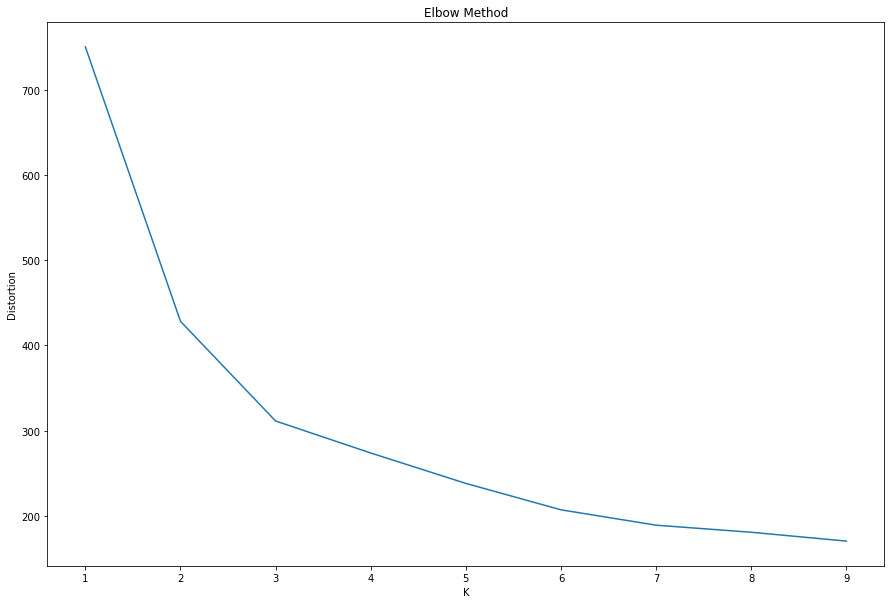

In [241]:
plt.figure(figsize=(15,10))
plt.plot(K, distortions)
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

The elbow method here shows that 3 clusters is the most appropriate in this case.

In [247]:
km_2 = KMeans(n_clusters=3)
km_2.fit(scaled)
km_2.cluster_centers_

array([[-0.92279764,  0.94281867,  0.67017879,  0.79729816,  0.80241799,
         0.7856849 ],
       [ 1.37296168, -1.31456528, -1.36695785, -0.18624296, -1.28628101,
        -1.18618694],
       [ 0.04075791, -0.08823007,  0.16579157, -0.5635154 ,  0.01338635,
        -0.02560191]])

In [283]:
cluster_1 = []
cluster_2 = []
cluster_3 = []
for i in range(len(km.labels_)):
    if km_2.labels_[i] == 0:
        cluster_1.append(chicago_hs["School Name"].iloc[i])
    elif km_2.labels_[i] == 1:
        cluster_3.append(chicago_hs["School Name"].iloc[i])    
    else:
        cluster_2.append(chicago_hs["School Name"].iloc[i])

In [249]:
charter(cluster_1, raw_attendance)

{'Charter': 12, 'Non-Charter': 32}

In [250]:
charter(cluster_2, raw_attendance)

{'Charter': 26, 'Non-Charter': 27}

In [251]:
charter(cluster_3, raw_attendance)

{'Charter': 2, 'Non-Charter': 26}

When you further segment it with the appropriate number of clusters, you see that the groups are even more stratified in terms of the Charter schools with a large portion of them falling into the top or second performing cluster.

## Geo-code Locations

First we have to find the addresses of the local high schools within Chicago and convert them into coordinates in order to map them.

In [112]:
import requests

addresses = {}

for school in list(chicago_hs["School Name"]):
    search_term = ""
    search = school.split(" ")
    for word in search:
        search_term = search_term + word
        if word != search[-1]:
            search_term += "%20"
    url = "https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input=" + search_term + "&inputtype=textquery&fields=formatted_address&key=" + api_key
    response = requests.get(url).json()
    addresses[school] = response["candidates"][0]["formatted_address"]

In [270]:
address_coords = pd.Series(addresses).to_frame("Address")

In [271]:
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

locator = Nominatim(user_agent="myGeocoder")
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
address_coords['location'] = address_coords['Address'].apply(geocode)
address_coords['latitude'] = address_coords["location"].apply(lambda x: x.point[0] if x else None)
address_coords['longitude'] = address_coords["location"].apply(lambda x: x.point[1] if x else None)

In [284]:
address_coords = address_coords.dropna()
cluster_1.remove("NOBLE - MUCHIN HS")
cluster_3.remove("RICHARDS HS")

In [276]:
def mercator(df, lat="latitude", lon = "longitude"):
    k = 6378137
    df["x_coord"] = df[lon] * (k * np.pi/180.0)
    df["y_coord"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    
    return df

In [277]:
mercator(address_coords)

,Address,location,latitude,longitude,x_coord,y_coord
ACERO - DE LA CRUZ,"7416 N Ridge Blvd, Chicago, IL 60645, United S...","(7416-7430, North Ridge Boulevard, West Ridge,...",42.016547,-87.684980,-9.761047e+06,5.163458e+06
ACERO - GARCIA HS,"4248 W 47th St, Chicago, IL 60632, United States","(4248, West 47th Street, Archer Heights, Chica...",41.809092,-87.730789,-9.766147e+06,5.132425e+06
ACERO - SOTO HS,"5025 S St Louis Ave, Chicago, IL 60632, United...","(South Saint Louis Avenue, Brighton Park, Chic...",41.809193,-87.711042,-9.763948e+06,5.132440e+06
AIR FORCE HS,"3630 S Wells St, Chicago, IL 60609, United States","(3630, South Wells Street, Armour Square, Chic...",41.827880,-87.632958,-9.755256e+06,5.135231e+06
ALCOTT HS,"2957 N Hoyne Ave, Chicago, IL 60618, United St...","(Alcott College Prep, 2957, North Hoyne Avenue...",41.935310,-87.680334,-9.760530e+06,5.151294e+06
...,...,...,...,...,...,...
WORLD LANGUAGE HS,"3120 S Kostner Ave, Chicago, IL 60623, United ...","(Little Village Lawndale High School, 3120, So...",41.834567,-87.735292,-9.766648e+06,5.136230e+06
YOUNG HS,"211 S Laflin St, Chicago, IL 60607, United States","(Whitney M. Young Magnet High School, 211, Sou...",41.878192,-87.663108,-9.758613e+06,5.142751e+06
TEAM HS,"6201 S Stewart Ave, Chicago, IL 60621, United ...","(Team Englewood Community Academy, 6201, South...",41.782071,-87.634275,-9.755403e+06,5.128390e+06
URBAN PREP - WEST HS,"1326 W 14th Pl, Chicago, IL 60608, United States","(1326, West 14th Place, Near West Side, Univer...",41.862753,-87.660327,-9.758303e+06,5.140443e+06


In [285]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider

tile_provider = get_provider(CARTODBPOSITRON)

# range bounds supplied in web mercator coordinates
p = figure(x_range=(-9780000, -9745000), y_range=(5110000, 5160000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)

p.circle(x=address_coords.loc[cluster_1]["x_coord"], y=address_coords.loc[cluster_1]["y_coord"], size=10, fill_color="blue", fill_alpha=0.6)
p.circle(x=address_coords.loc[cluster_2]["x_coord"], y=address_coords.loc[cluster_2]["y_coord"], size=10, fill_color="red", fill_alpha=0.6)
p.circle(x=address_coords.loc[cluster_3]["x_coord"], y=address_coords.loc[cluster_3]["y_coord"], size=10, fill_color="green", fill_alpha=0.6)

output_notebook()
show(p)

Loading BokehJS ...

Looking at the visual breakdown, it doesn't seem that there is a significant pattern of performance in relation to the location of the schools. However, let's look at the division of neighborhoods as Chicago is a very stratified city.

In [306]:
gdf = geopandas.GeoDataFrame(address_coords, geometry=geopandas.points_from_xy(address_coords.longitude, address_coords.latitude))

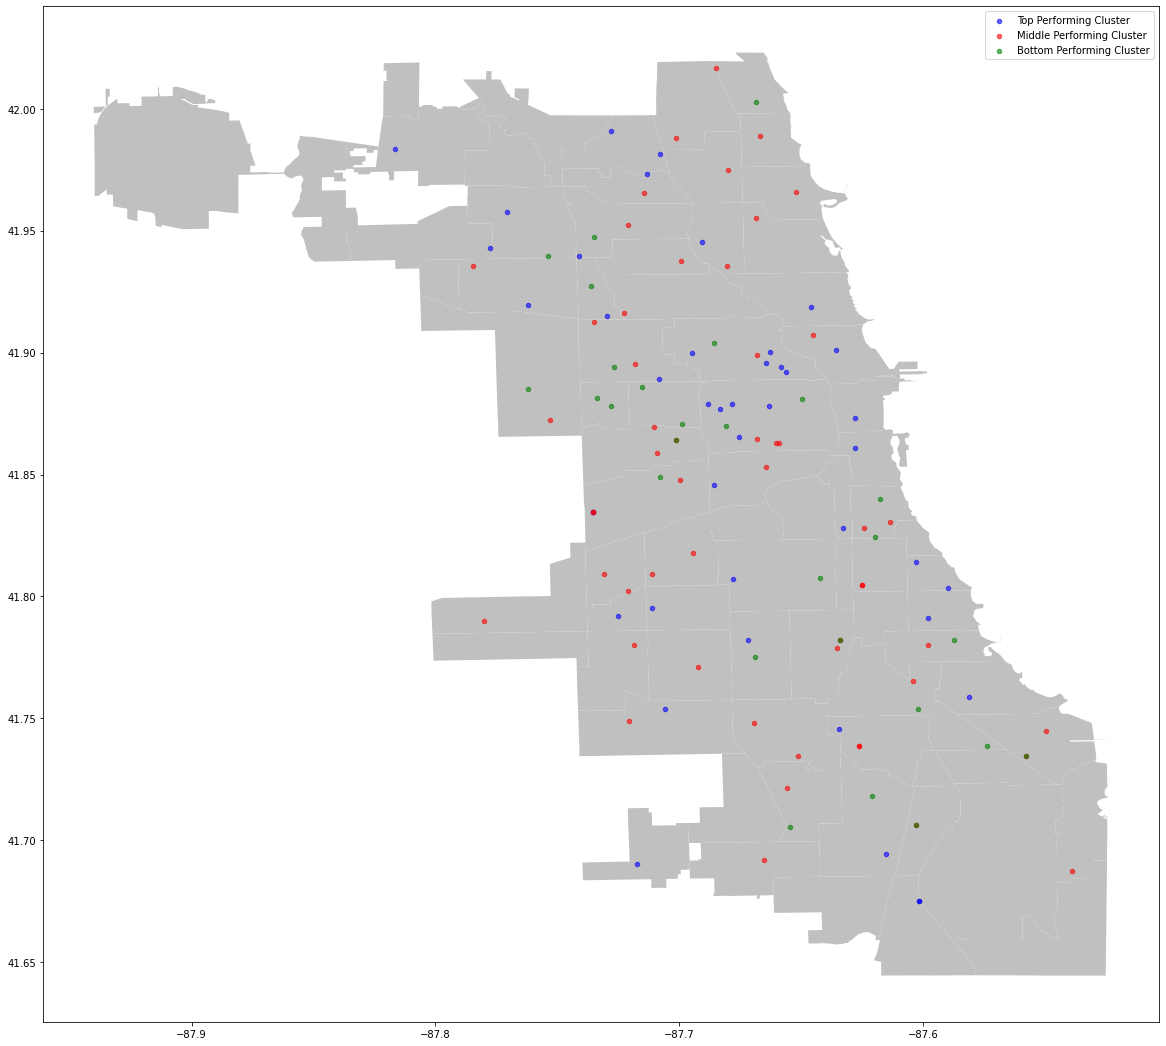

In [313]:
import geopandas
import descartes

neighborhoods = geopandas.read_file("/Users/nathanlee/Downloads/Boundaries - Community Areas (current)/geo_export_c50bf0f9-7241-4a84-a4ac-562d764a2e85.shp")

fig,ax = plt.subplots(figsize = (20,20))
neighborhoods.plot(ax = ax, color = "silver")


gdf.loc[cluster_1].plot(ax = ax, markersize = 20, color = "blue", alpha = 0.6, label = "Top Performing Cluster")
gdf.loc[cluster_2].plot(ax = ax, markersize = 20, color = "red", alpha = 0.6, label = "Middle Performing Cluster")
gdf.loc[cluster_3].plot(ax = ax, markersize = 20, color = "green", alpha = 0.6, label = "Bottom Performing Cluster")
plt.legend()

Looking at an overlay of the neighborhoods, it seems that there are better performing regions like North Chicago which is home to some of the wealthiest neighborhoods like Forest Glen and Lincoln Park. Another higher performing group seems to exist in the Southwest corner of Chicago near Midway Airport. Plenty of the schools in the third cluster exist in West Chicago which is where many lowest income neighborhoods exist (according to the map of Chicago in 2017 below from a study conducted by the [Voorhees Center from the University of Illinois at Chicago](https://voorheescenter.wordpress.com/2018/06/06/who-can-live-in-chicago-part-i/))

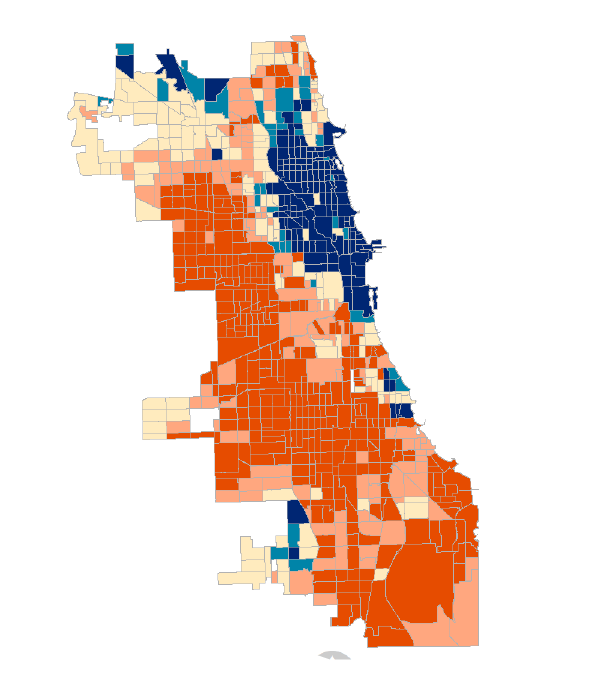